# Notebook to Visualize Huc10 Results - Prototype Model w/ New Data

# Step 0 = Set up Notebook

In [2]:
# import needed libaries
import os
import boto3
import mlflow
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from snowML import snow_types as st

In [4]:
# initialize erathengine credentials
import ee
ee.Authenticate()

True

# Step1 - Download ML Metrics

In [5]:
# function to retrieve metrics from ML server 
def load_ml_metrics(tracking_uri, run_id, save_local=False):
    mlflow.set_tracking_uri(tracking_uri)
    client = mlflow.MlflowClient()
    # Get all metric keys from the run
    run_data = client.get_run(run_id).data
    metric_keys = run_data.metrics.keys()
    # Retrieve full metric history for each key
    all_metrics = []
    for metric in metric_keys:
        history = client.get_metric_history(run_id, metric)
        for record in history:
            all_metrics.append({
                "Metric": metric,
                "Step": record.step,
                "Value": record.value
            })
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame(all_metrics)
    
    # Save to CSV if needed
    if save_local:
        f_out = f"run_id_data/metrics_from_{run_id}.csv"
        metrics_df.to_csv(f_out, index=False)

    return metrics_df

In [6]:
# function to extract only a specific metric
def extract_metric(df, metric_name):
    """Extracts rows where the Metric column ends with 'metric_name' and returns only Metric and Value columns."""
    return df[df['Metric'].str.endswith(metric_name)][['Metric', 'Value']].sort_values(by='Metric')

In [7]:
# set mlFlow tracking server 
tracking_uri = "arn:aws:sagemaker:us-west-2:677276086662:mlflow-tracking-server/dawgsML"

# define our run_ids by recognizable names 
orig_30 = "0d8be0dc44a447099f7901c83032a59e"  # orig data, 30 epochs, MLflow name is legendary toad 940 
orig_200 = "41f1a7b318f94b2bb2c4fdfbf892a018"  # (orig data, 200 epochs, MLflow name is clumsy-ray-666
new_10 = "69d929bbdfdd43b4a2f45b823d945eb7" # new data 10 epochs, ML flow name is dapper pig 680

In [8]:
df_orig30 = load_ml_metrics(tracking_uri, orig_30)
df_orig30_tkge = extract_metric(df_orig30, "test_kge")
df_orig30_tmse = extract_metric(df_orig30, "test_mse")


In [9]:
df_orig30_tkge

,Metric,Value
10,1711000504_test_kge,0.387495
6,1711000505_test_kge,0.450601
20,1711000506_test_kge,0.443174
14,1711000507_test_kge,0.543197
27,1711000508_test_kge,0.488562
4,1711000509_test_kge,0.488394
13,1711000511_test_kge,0.513360


In [10]:
df_orig200 = load_ml_metrics(tracking_uri, orig_200)
df_orig200_tkge = extract_metric(df_orig200, "test_kge")
df_orig200_tmse = extract_metric(df_orig200, "test_mse")


In [11]:
df_orig200_tkge

,Metric,Value
22,1711000504_test_kge,0.469891
3,1711000505_test_kge,0.602654
20,1711000506_test_kge,0.524301
5,1711000507_test_kge,0.665654
15,1711000508_test_kge,0.667101
27,1711000509_test_kge,0.707040
12,1711000511_test_kge,0.528663


# Step 2 - Plot Results 

In [12]:
# define a function to plot results side by side 

def plot_side_by_side(df1, df2, label1, label2):
    """Plots a side-by-side bar chart comparing values from two DataFrames by Metric."""
    
    # Merge DataFrames on 'Metric'
    merged_df = df1.merge(df2, on='Metric', suffixes=(f'_{label1}', f'_{label2}'))
    
    metrics = merged_df['Metric']
    values1 = merged_df[f'Value_{label1}']
    values2 = merged_df[f'Value_{label2}']
    
    x = np.arange(len(metrics))  # Label locations
    width = 0.4  # Bar width
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, values1, width, label=label1, color='b', alpha=0.7)
    bars2 = ax.bar(x + width/2, values2, width, label=label2, color='r', alpha=0.7)

    ax.set_xlabel("Metric")
    ax.set_ylabel("Value")
    ax.set_title("Side-by-Side Metric Comparison")
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha="right")
    ax.legend()

    plt.show()



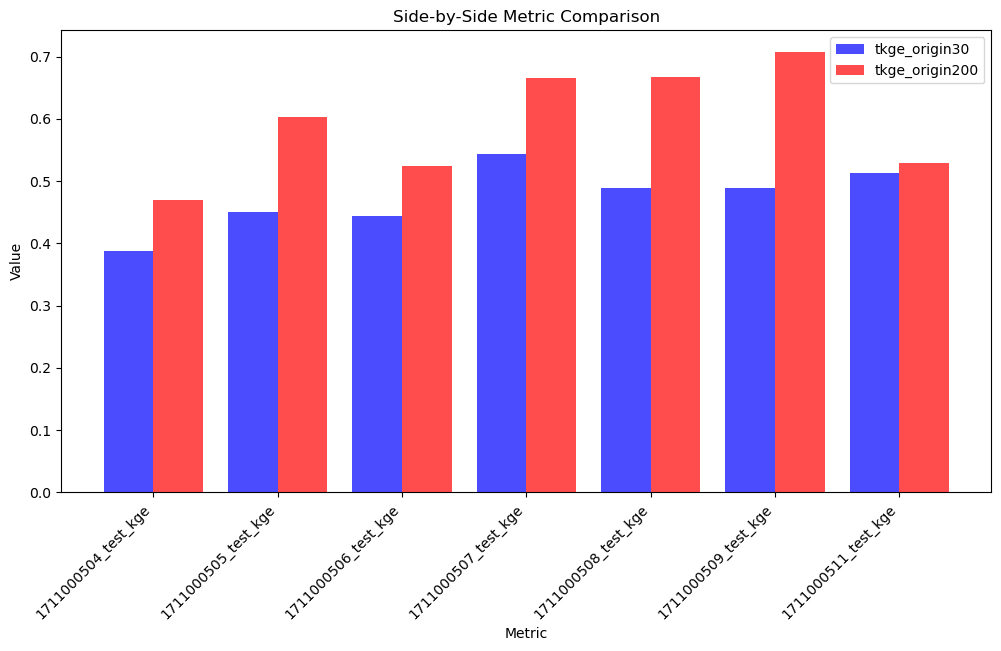

In [13]:
plot_side_by_side(df_orig30_tkge, df_orig200_tkge, "tkge_origin30", "tkge_origin200")


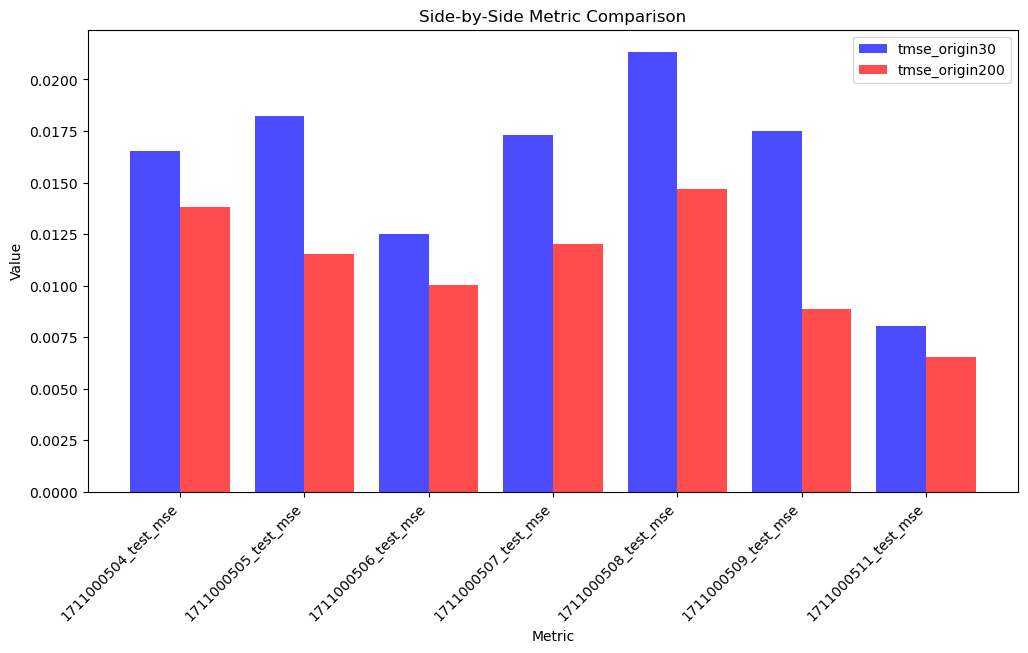

In [37]:
plot_side_by_side(df_orig30_tmse, df_orig200_tmse, "tmse_origin30", "tmse_origin200")

In [14]:
df_new10 = load_ml_metrics(tracking_uri, new_10)

In [15]:
df_new10

,Metric,Step,Value
0,train_mse_170103040305,0,0.029135
1,train_mse_170103040305,1,0.008264
2,train_mse_170103040305,2,0.003490
3,train_mse_170103040305,3,0.002993
4,train_mse_170103040305,4,0.002356
...,...,...,...
3589,train_mse_170200100101,4,0.002884
3590,train_mse_170200100101,5,0.002963
3591,train_mse_170200100101,6,0.002589
3592,train_mse_170200100101,7,0.004654
